The point of this notebook is to demonstrate the SINDy code using a simple example from population growth:

The model we want to back out using SINDy will be

$\frac{dP}{dt}=r P \cdot \left(1 - \frac{P}{K}\right)$

where the constant r defines the growth rate and K is the carrying capacity.

This model has a nice closed form solution that we can use to generate data:

$P(t) = \frac{K P_0 e^{rt}}{K + P_0 \left( e^{rt} - 1\right)} = \frac{K}{1+\left(\frac{K-P_0}{P_0}\right)e^{-rt}}$.

# Import

In [11]:
%matplotlib notebook

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
import sklearn as skl
import sklearn.linear_model

In [26]:
import importlib
sd = importlib.import_module('sindy')

In [3]:
sd = importlib.reload(sd)

# Derivative example

First, let's check that our derivative method does what we expect by differentiating sine.

In [32]:
d_sg = sd.SavitzkyGolay({'left': 2, 'right': 2, 'order': 3})

<IPython.core.display.Javascript object>


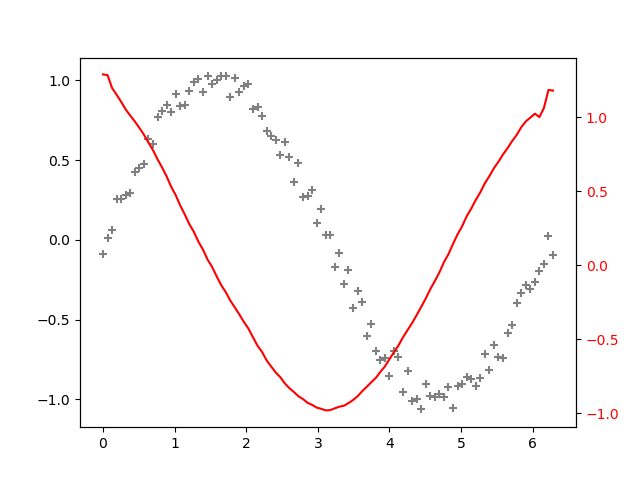

In [44]:
# Data
t = np.linspace(0,2*np.pi,100)
x = np.sin(t) + .1 * (2*np.random.rand(len(t))-1)

# Derivative
pts = list(range(len(x)))
sg_deriv = d_sg.compute_for(t, x, pts)

# Plot on shared axis
fig, ax1 = plt.subplots(1)

h1 = ax1.scatter(t, x, marker='+', color='gray')
ax2 = ax1.twinx()
h2, = ax2.plot(t, list(sg_deriv), color='red')
ax2.tick_params(axis='y', labelcolor='red')

# SINDy example

<IPython.core.display.Javascript object>


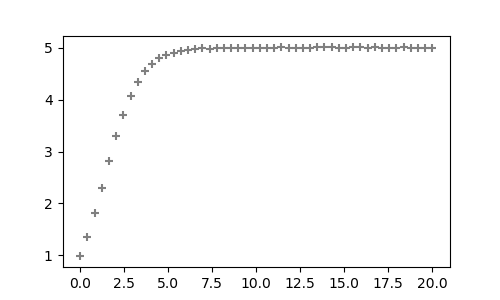

In [113]:
K = 5
r = 1
P0 = 1
noise = .01

t = np.linspace(0,20,50)
x = K*P0*np.exp(r*t)/(K+P0*(np.exp(r*t)-1)) + noise * (2*np.random.rand(len(t))-1)

fig, ax1 = plt.subplots(1, figsize=[5,3])
ax1.scatter(t, x, color='gray', marker='+')

In [114]:
model = skl.linear_model.Lasso(alpha=1e-5, fit_intercept=False)

order = 5
# Library for 1d vector
library = [lambda x, i=i: np.power(x[:,0], i) for i in range(order + 1)]
lib_str = ['$x^{0}$'.format(i) for i in range(order + 1)]

sindy = sd.SINDy({'library': library, 'model': model, 'derivative': d_sg})

(Below) The black/gray show the data and prediction from the SINDy model. The red shows the numerical $\dot{x}$ and the result from multiplying the dictionary times the solution vector.

<IPython.core.display.Javascript object>


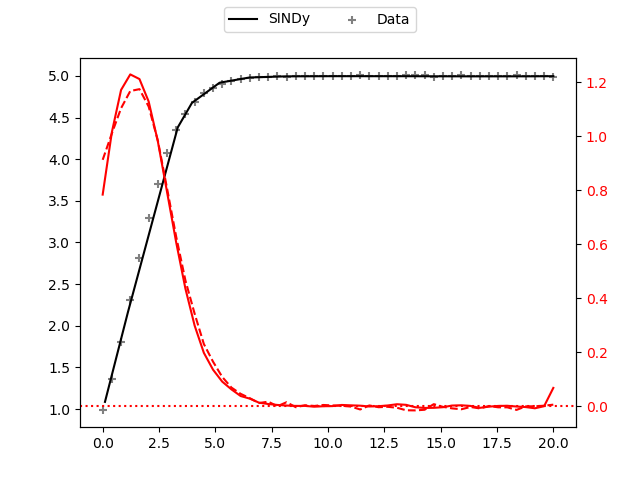

In [115]:
# SINDy
soln = sindy.identify(t, x)

# Integrate SINDy diff-eq
p_t, p_x = sindy.integrate()

# Plot
fig, ax1 = plt.subplots(1)
h1 = ax1.scatter(t, x, color='gray', marker='+')
h2, = ax1.plot(p_t, p_x, color='k')

ax2 = ax1.twinx()
ax2.axhline(0, t.min(), t.max(), color='r', linestyle=':')
h3, = ax2.plot(sindy.t, sindy.ThX@soln, color='r', linestyle='--')
h4, = ax2.plot(sindy.t, sindy.x_dot, color='r')
ax2.tick_params(axis='y', labelcolor='red')

fig.legend([h2, h1], ['SINDy', 'Data'], ncol=2, loc='upper center')

(Below) The SINDy loadings are shown (renormalized so the the initial values match).

<IPython.core.display.Javascript object>


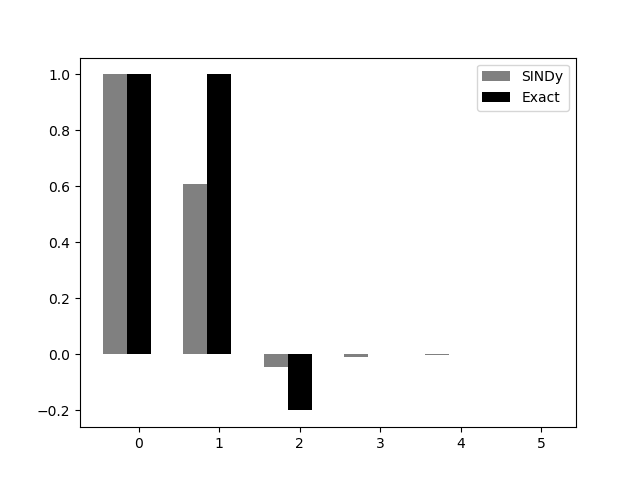

In [117]:
fig, ax = plt.subplots(1)

w = 0.3
index = np.arange(len(soln))

exact = np.zeros(len(index))
exact[0:3] = [P0, r, -r/K]

ax.bar(index-w, soln/soln[0], width=w, color='gray', align='center')
ax.bar(index, exact, width=w, color='k', align='center')
ax.legend(['SINDy', 'Exact'])